In [10]:
import os
import shutil
import pickle
from PIL import Image
from hashlib import sha256
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import models
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, image

from keras.applications.xception import Xception, decode_predictions
from keras.applications.xception import preprocess_input as preprocess_input_xce

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_incV3

from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input as preprocess_input_eff

### Variables

In [2]:
PIXELS = 300
path = './images/'
trainList = pd.read_csv('train.csv')
testList = pd.read_csv('test.csv')

## Create directories and copy images

### Create directories

In [3]:
if not os.path.exists('./train'):
    os.mkdir('./train')
if not os.path.exists('./train/cup'):
    os.mkdir('./train/cup')     
if not os.path.exists('./train/fork'):
    os.mkdir('./train/fork')     
if not os.path.exists('./train/glass'):
    os.mkdir('./train/glass')     
if not os.path.exists('./train/knife'):
    os.mkdir('./train/knife')     
if not os.path.exists('./train/plate'):
    os.mkdir('./train/plate')     
if not os.path.exists('./train/spoon'):
    os.mkdir('./train/spoon')     
    
if not os.path.exists('./test'):
    os.mkdir('./test')
    
if not os.path.exists('./Models'):
    os.mkdir('./Models')    

### Copy images to directories

In [4]:
for img in os.listdir('./images'):
    
    if (not os.path.exists(f'./train/{img}')) and (not(os.path.exists(f'./test/{img}'))):
        imgName = int(img.split('.')[0])
        
        if imgName in trainList.Id.values:
            
            imgLabel = trainList[trainList.Id == imgName].label.values
            
            if imgLabel == 'cup':
                shutil.copy(f'./images/{img}', f'./train/cup/{img}')
            elif imgLabel == 'fork':
                shutil.copy(f'./images/{img}', f'./train/fork/{img}')
            elif imgLabel == 'glass':
                shutil.copy(f'./images/{img}', f'./train/glass/{img}')
            elif imgLabel == 'knife':
                shutil.copy(f'./images/{img}', f'./train/knife/{img}')
            elif imgLabel == 'plate':
                shutil.copy(f'./images/{img}', f'./train/plate/{img}')
            elif imgLabel == 'spoon':
                shutil.copy(f'./images/{img}', f'./train/spoon/{img}')

        else:            
            
            shutil.copy(f'./images/{img}', f'./test/{img}')
            
totalTrainImgs = len(os.listdir("./train/cup")) + len(os.listdir("./train/fork")) + \
                len(os.listdir("./train/glass")) + len(os.listdir("./train/knife")) + \
                len(os.listdir("./train/plate")) + len(os.listdir("./train/spoon"))

totalTestImgs = len(os.listdir("./test"))

print(f'There is a total of {totalTrainImgs} images in the training set')
print(f'There is a total of {totalTestImgs} images in the test set')            

There is a total of 5559 images in the training set
There is a total of 3808 images in the test set


### Image Generators

In [21]:
def ProcInputs(modelName):
    
    preprocessInputs = {'Xception': preprocess_input_xce,
                    'InceptionV3': preprocess_input_incV3,
                    'efficientnetB7': preprocess_input_eff,
                   }
    return preprocessInputs[modelName]


def DataGenerators (modelName, split=0.2):
   
    preprocess_input = ProcInputs(modelName)
    
    dataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=split,
                                      )    

    trainGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                         batch_size=32,
                                                         target_size=(PIXELS, PIXELS), 
                                                         subset="training",
                                                         shuffle=True,
                                                         class_mode='categorical')

    valGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                       batch_size=16,
                                                       target_size=(PIXELS, PIXELS),
                                                       subset="validation",
                                                       shuffle=True,
                                                       class_mode='categorical')
    
    return trainGenerator, valGenerator

## Testing 3 different models
### Xception, InceptionV3 and EfficientNetB7

### Getting model configurations

In [6]:
def GetModel(modelName):
    
    basemodel_Xce = tf.keras.applications.Xception(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(PIXELS, PIXELS, 3))

    basemodel_Inc = tf.keras.applications.InceptionV3(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(PIXELS, PIXELS, 3))
    
    basemodel_EffB7 = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                       include_top=False,
                                                       input_shape=(PIXELS, PIXELS, 3)) 

   
    basemodels = {'Xception': basemodel_Xce,
                  'InceptionV3': basemodel_Inc,
                  'efficientnetB7': basemodel_EffB7,
                 }
    
    return basemodels[modelName]

### Building the model

In [12]:
def MakeModel(modelName = 'Xception', learning_rate = 0.001, size_inner=16, droprate=0.3):
    
    base_model = GetModel(modelName)
    
    base_model.trainable = False

    inputs = Input(shape=(PIXELS, PIXELS, 3))
    base = base_model(inputs, training=False)
    vectors = layers.GlobalAveragePooling2D()(base)
    
    inner = layers.Dense(size_inner, activation='relu')(vectors)
    drop = layers.Dropout(droprate)(inner)
    
    outputs = layers.Dense(6, activation='softmax')(drop)
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Checkpointing

In [8]:
def GetCheckpoint(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint("./Models/" + modelName + '_{epoch:02d}_{val_accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')
    return checkpoint

def GetCheckpointFull(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint("./Models/" + modelName + '_{epoch:02d}_{accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='accuracy',
                                                 mode='max')
    return checkpoint


### Model preparation

In [13]:
def RunModel(learningRates, modelName, steps_per_epoch=50, epochs=10):
    
    scores = {}
    size = 128
    droprate = 0.3
    trainGenerator, valGenerator = DataGenerators (modelName)
    print()

    for lr in learningRates:
        print(f'Learning rate: {lr}')
        checkpoint = GetCheckpoint(modelName + '_' + f'lr{lr}')
        model = MakeModel(modelName=modelName, learning_rate=lr)
        history = model.fit(trainGenerator,
                            validation_data=valGenerator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            callbacks=[checkpoint])
        scores[lr] = history.history
        print('\n')
    
    return model, history, scores

### Plot history

In [10]:
def PlotHistory(scores, lims=[0.9,0.98], xaxis=10):
        
    for lr , hist in scores.items():
        plt.plot(hist['val_accuracy'], label=lr)

    plt.xticks(np.arange(xaxis))
    plt.ylim(lims[0], lims[1])
    plt.legend()

### Finding best Learning rates for models

### Xception

In [11]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'Xception'
model_X, history_X, scores_X = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 20s 333ms/step - loss: 1.3297 - accuracy: 0.4885 - val_loss: 0.8775 - val_accuracy: 0.8693
Epoch 2/10


C:\Users\clavi\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


50/50 [==============================] - 15s 300ms/step - loss: 0.8204 - accuracy: 0.7478 - val_loss: 0.5501 - val_accuracy: 0.9261
Epoch 3/10
50/50 [==============================] - 15s 302ms/step - loss: 0.6353 - accuracy: 0.8025 - val_loss: 0.3959 - val_accuracy: 0.9342
Epoch 4/10
50/50 [==============================] - 15s 295ms/step - loss: 0.5298 - accuracy: 0.8363 - val_loss: 0.2919 - val_accuracy: 0.9477
Epoch 5/10
50/50 [==============================] - 15s 294ms/step - loss: 0.4169 - accuracy: 0.8619 - val_loss: 0.2398 - val_accuracy: 0.9486
Epoch 6/10
50/50 [==============================] - 15s 294ms/step - loss: 0.3809 - accuracy: 0.8844 - val_loss: 0.2097 - val_accuracy: 0.9522
Epoch 7/10
50/50 [==============================] - 15s 296ms/step - loss: 0.3491 - accuracy: 0.8894 - val_loss: 0.1908 - val_accuracy: 0.9585
Epoch 8/10
50/50 [==============================] - 15s 291ms/step - loss: 0.3222 - accuracy: 0.8968 - val_loss: 0.1776 - val_accuracy: 0.9540
Epoch 9/10

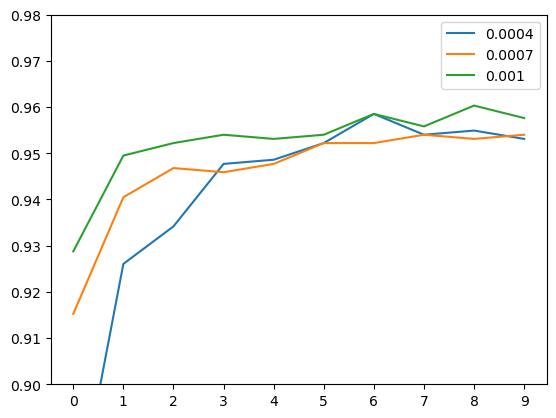

In [12]:
PlotHistory(scores_X, lims=[0.9, 0.98])

### InceptionV3

In [13]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'InceptionV3'
model_IN, history_IN, scores_IN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 20s 333ms/step - loss: 1.3010 - accuracy: 0.5281 - val_loss: 0.8066 - val_accuracy: 0.8206
Epoch 2/10
50/50 [==============================] - 14s 288ms/step - loss: 0.8238 - accuracy: 0.7206 - val_loss: 0.5587 - val_accuracy: 0.9008
Epoch 3/10
50/50 [==============================] - 14s 288ms/step - loss: 0.6958 - accuracy: 0.7738 - val_loss: 0.4420 - val_accuracy: 0.9216
Epoch 4/10
50/50 [==============================] - 15s 302ms/step - loss: 0.5913 - accuracy: 0.8006 - val_loss: 0.3989 - val_accuracy: 0.9333
Epoch 5/10
50/50 [==============================] - 15s 296ms/step - loss: 0.5343 - accuracy: 0.8194 - val_loss: 0.3264 - val_accuracy: 0.9279
Epoch 6/10
50/50 [==============================] - 15s 297ms/step - loss: 0.5283 - accuracy: 0.8163 - val_loss: 0.3111 - val_accuracy: 0.9360
Epoch 7/10
50/50 [=================

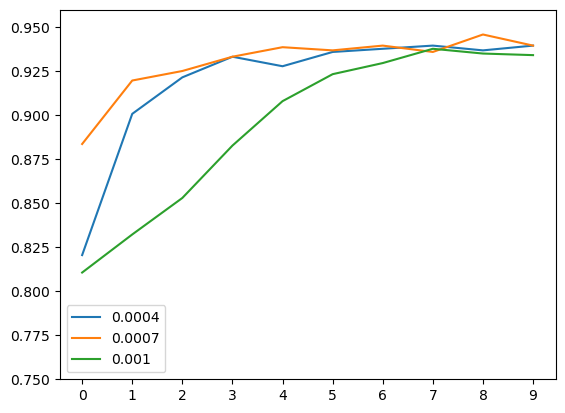

In [14]:
PlotHistory(scores_IN, lims=(0.75, 0.96))

### EfficientnetB7

In [15]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'efficientnetB7'
model_EN, history_EN, scores_EN = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 39s 579ms/step - loss: 1.0390 - accuracy: 0.7250 - val_loss: 0.4554 - val_accuracy: 0.9459
Epoch 2/10
50/50 [==============================] - 25s 499ms/step - loss: 0.4678 - accuracy: 0.8775 - val_loss: 0.2492 - val_accuracy: 0.9567
Epoch 3/10
50/50 [==============================] - 25s 509ms/step - loss: 0.3659 - accuracy: 0.9006 - val_loss: 0.1878 - val_accuracy: 0.9576
Epoch 4/10
50/50 [==============================] - 25s 501ms/step - loss: 0.2948 - accuracy: 0.9125 - val_loss: 0.1587 - val_accuracy: 0.9585
Epoch 5/10
50/50 [==============================] - 25s 498ms/step - loss: 0.2683 - accuracy: 0.9089 - val_loss: 0.1429 - val_accuracy: 0.9612
Epoch 6/10
50/50 [==============================] - 25s 499ms/step - loss: 0.2515 - accuracy: 0.9242 - val_loss: 0.1336 - val_accuracy: 0.9621
Epoch 7/10
50/50 [=================

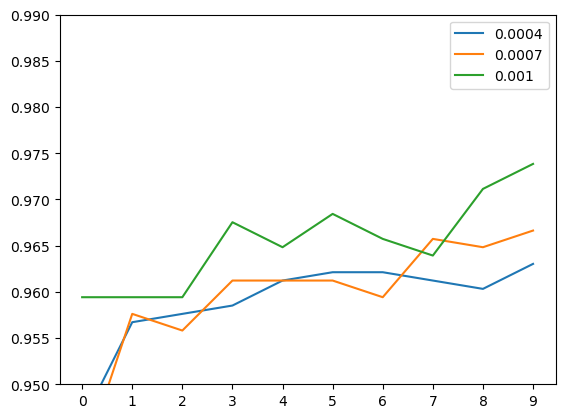

In [16]:
PlotHistory(scores_EN, lims=(0.95,0.99))

### Predict test labels

In [14]:
effModelName = 'efficientnetB7'
effModel = MakeModel(modelName)
effModel.load_weights('Models/efficientnetB7_lr0.001_10_0.974.h5')

InModelName = 'efficientnetB7'
InModel = MakeModel(modelName)
InModel.load_weights('Models/efficientnetB7_lr0.001_10_0.974.h5')

XModelName = 'efficientnetB7'
XModel = MakeModel(modelName)
XModel.load_weights('Models/efficientnetB7_lr0.001_10_0.974.h5')


NameError: name 'modelName' is not defined

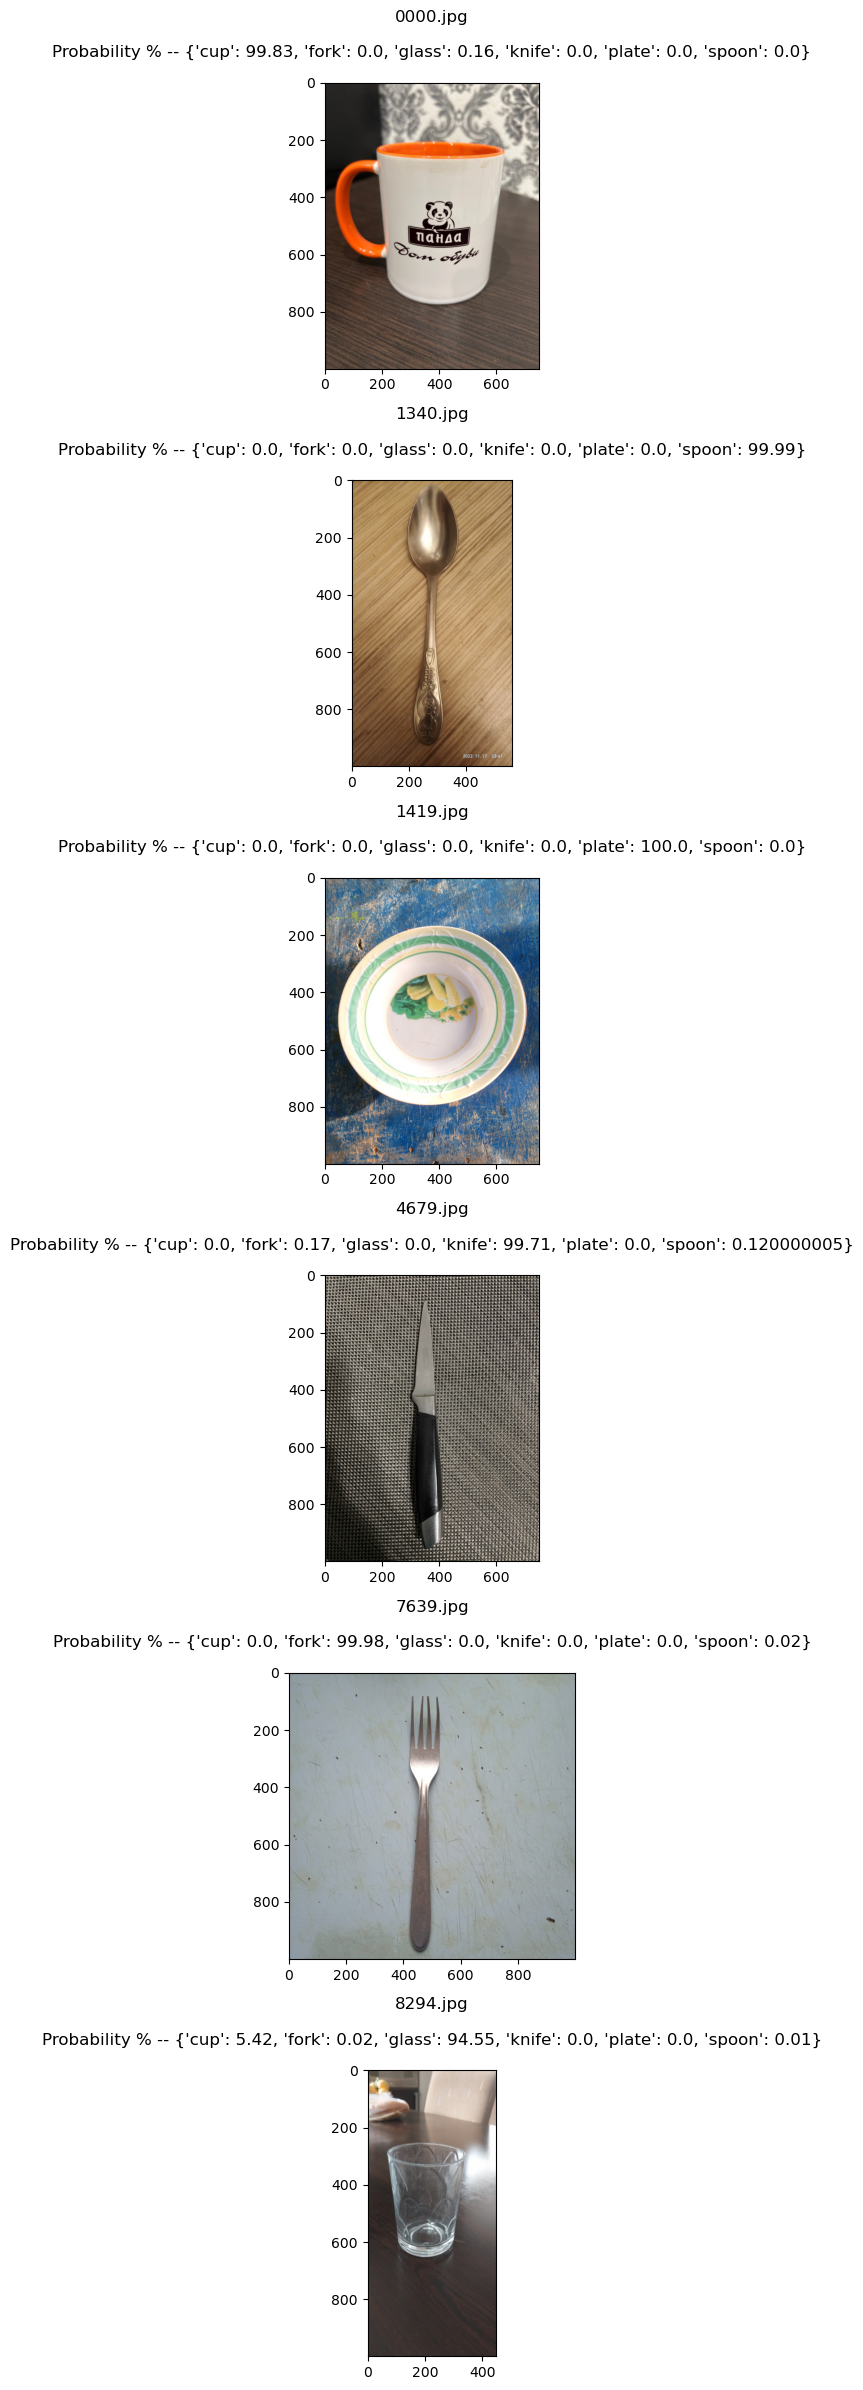

In [25]:
count =0
res = []
classes = {'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}
labels = dict((v, k) for k, v in classes.items())
PIXELS =300
modelName = 'efficientnetB7'
preprocessInput = ProcInputs(modelName)

effModel = load_model('Models/best_efficientnetB7_lr0.001_10_0.974.h5')

testImages = ['0000.jpg', '1340.jpg', '1419.jpg', '4679.jpg', '7639.jpg', '8294.jpg']

fig, ax = plt.subplots(6,1, figsize=(10, 24))

for file, ax in zip(testImages, ax.ravel()):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(PIXELS, PIXELS))
    x = np.array(img)
    X = np.array([x])
    X = preprocessInput(X)
    preds = np.round(effModel.predict(X),4) * 100

    #label = labels[np.argmax(preds[0])]
    label = preds[0]
    Id = file.split('.')[0]
    res.append([Id, label])
   
    imgRead = mpimg.imread(imgPath)
    ax.imshow(imgRead)
    results = dict(zip(classes.keys(),preds[0]))
    ax.set_title(f'{file}\n\nProbability % -- {results}\n')
fig.tight_layout()